In [1]:
import pandas as pd
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()

removing link inputs
removing link outputs


## Download study data files

In [2]:
required_files = [
    "Demographics.csv",
    "Primary_Clinical_Diagnosis.csv",
    "Cognitive_Categorization.csv",
    "Medical_Conditions_Log.csv",
    "Concomitant_Medication_Log.csv",
    "Prodromal_History.csv",
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


## Inspect prodromal data

In [3]:
import os
prodromal = pd.read_csv(os.path.join(utils.study_files_dir, 'Prodromal_History.csv'))[["PATNO", "EVENT_ID", "RBDDIAG", "RBDPSG", "ORIG_ENTRY"]]
prodromal["ORIG_ENTRY_formatted"] = pd.to_datetime(prodromal['ORIG_ENTRY'])

Total number of records: 101
Unique subjects: 101


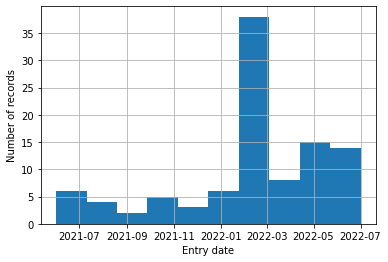

In [4]:
from matplotlib import pyplot as plt
print(f'Total number of records: {len(prodromal)}')
print(f'Unique subjects: {len(pd.unique(prodromal["PATNO"]))}')
prodromal['ORIG_ENTRY_formatted'].hist()
plt.xlabel('Entry date')
plt.ylabel('Number of records')
plt.show()

In [5]:
prodromal.groupby(['RBDDIAG', 'RBDPSG'], dropna=False).count()

PATNO  EVENT_ID  ORIG_ENTRY  ORIG_ENTRY_formatted
RBDDIAG RBDPSG                                                   
0.0     0.0         1         1           1                     1
1.0     0.0         6         6           6                     6
        1.0        52        52          52                    52
NaN     NaN        42        42          42                    42

There are 52 RBD subjects with a polysomnography.

## Inclusion/exclusion criteria

In [6]:
import os.path as op

# Prodromal history
prodr_hist = pd.read_csv(os.path.join(utils.study_files_dir, 'Prodromal_History.csv'))[["PATNO", "RBDDIAG", "RBDPSG"]]

# MRI info
mri = pd.read_csv(op.join(utils.study_files_dir, "MRI_info.csv"))[
    ["Subject ID", "Visit code", "Description", "Age"]
]
mri.rename(columns={"Subject ID": "PATNO", "Visit code": "EVENT_ID"}, inplace=True)

# Demographics
dem = pd.read_csv(os.path.join(utils.study_files_dir, "Demographics.csv"))[["PATNO", "SEX"]]

# Diagnosis
diag = pd.read_csv(op.join(utils.study_files_dir, "Primary_Clinical_Diagnosis.csv"))[
    ["PATNO", "EVENT_ID", "PRIMDIAG", "OTHNEURO"]
]

# Cognitive Categorization
cog_cat = pd.read_csv(op.join(utils.study_files_dir, "Cognitive_Categorization.csv"))[
    ["PATNO", "EVENT_ID", "COGSTATE"]
]

# Medical condition
med_cond = pd.read_csv(op.join(utils.study_files_dir, "Medical_Conditions_Log.csv"))[
    ["PATNO", "EVENT_ID", "MHCAT"]
].groupby(['PATNO', 'EVENT_ID'])[['MHCAT']].aggregate(lambda x: tuple(set(x))) # aggregate all codes in a tuple

# Medication
meds = pd.read_csv(op.join(utils.study_files_dir, "Concomitant_Medication_Log.csv"))[
    ["PATNO", "EVENT_ID", "SEQNO", "CMTRT"]
].groupby(['PATNO', 'EVENT_ID'])[['CMTRT']].aggregate(lambda x: tuple(x)) # aggregate all meds in a tuple

def included(subjects):
    '''
    Return subjects complying to the inclusion criteria mentioned before.
    
    Parameters
    ----------
    subjects: DataFrame. Has to contain columns PATNO and EVENT_ID and PRIMDIAG
    '''
    temp =  (subjects.merge(dem, on="PATNO", how="inner") # Sex is available
     .merge(diag[diag['PRIMDIAG'].isin([17, 25])], on=["PATNO", "EVENT_ID"], how="inner") # Subject is healthy or prodromal
     .merge(mri, on=["PATNO", "EVENT_ID"], how="inner")  # MRI usable for VBM is available
     .merge(cog_cat[cog_cat["COGSTATE"] != 3], how="inner", on=["PATNO", "EVENT_ID"])  # No dementia
     .merge(med_cond, on=["PATNO", "EVENT_ID"], how="left")
     .merge(meds, on=["PATNO", "EVENT_ID"], how="left")
     
             [
        [
            "PATNO",
            "EVENT_ID",
            "RBDSQ",
            "Q6",
            "SEX",
            "Age",
            "Description",
            "PRIMDIAG",
            "COGSTATE",
            "MHCAT",
            "CMTRT",
        ]
    ]
            )
    
    # Check medical condition and return
    def check_mhcat(x):
        import numpy as np
        if type(x) == tuple:
            return not ("1P" in x or "1Q" in x)
        else:
            return np.isnan(x)
        
    return temp[(temp["MHCAT"].apply(check_mhcat))]  # No neurological or psychiatric illness and no evidence of central nervous system (CNS) comorbidities


### RBDDIAG=1 and RBDPSG=1

In [7]:
subjects = (prodr_hist[(prodr_hist['RBDDIAG']==1) & (prodr_hist['RBDPSG']==1)])
print(f'Number of subjects remaining {len(pd.unique(subjects["PATNO"]))}')
print(f'Number of records remaining {len(subjects)}')

Number of subjects remaining 52
Number of records remaining 52


### Sex is available

In [8]:
subjects = subjects.merge(dem, on="PATNO", how="inner")
print(f'Number of subjects remaining {len(pd.unique(subjects["PATNO"]))}')
print(f'Number of records remaining {len(subjects)}')

Number of subjects remaining 47
Number of records remaining 47


### PRIMDIAG is in [17, 25]

In [9]:
subjects = subjects.merge(diag[diag['PRIMDIAG'].isin([17, 25])], on=["PATNO"], how="left") # Subject is healthy or prodromal

In [10]:
print(f'Number of subjects remaining {len(pd.unique(subjects["PATNO"]))}')
print(f'Number of records remaining {len(subjects)}')

Number of subjects remaining 47
Number of records remaining 63


### MRI is available

In [11]:
subjects = subjects.merge(mri, on=["PATNO", "EVENT_ID"], how="inner")  # MRI usable for VBM is available
print(f'Number of subjects remaining {len(pd.unique(subjects["PATNO"]))}')
print(f'Number of records remaining {len(subjects)}')

Number of subjects remaining 7
Number of records remaining 8


### No dementia

In [12]:
subjects = subjects.merge(cog_cat[cog_cat["COGSTATE"] != 3], how="inner", on=["PATNO", "EVENT_ID"])  # No dementia
print(f'Number of subjects remaining {len(pd.unique(subjects["PATNO"]))}')
print(f'Number of records remaining {len(subjects)}')

Number of subjects remaining 7
Number of records remaining 8


### MHCAT not in 1P or 1Q (no neuro or psych disease)

In [13]:
# Check medical condition and return
def check_mhcat(x):
        import numpy as np
        if type(x) == tuple:
            return not ("1P" in x or "1Q" in x)
        else:
            return np.isnan(x)

subjects = subjects.merge(med_cond, on=["PATNO", "EVENT_ID"], how="left")
subjects = subjects[subjects["MHCAT"].apply(check_mhcat)]

print(f'Number of subjects remaining {len(pd.unique(subjects["PATNO"]))}')
print(f'Number of records remaining {len(subjects)}')

Number of subjects remaining 6
Number of records remaining 7


### Medication

In [14]:
subjects.merge(meds, on=["PATNO", "EVENT_ID"], how="left").groupby("CMTRT").count()[["PATNO"]]

,PATNO
CMTRT,
"(Benadryl, Spiriva)",2
"(Elequis,)",1
"(esomeprazole, clonazepam, ibandronate, gemfibrilosil)",1
"(melatonin,)",1
